In [1]:
import sys
from pathlib import Path

# Add parent directory to Python path
parent_dir = Path().resolve().parent
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))

import torch
import scanpy as sc
import anndata as ad
import celldiffusion as cd


/Users/liuyuchen/mamba/envs/CellDiffusion_env/lib/python3.11/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/Users/liuyuchen/mamba/envs/CellDiffusion_env/lib/python3.11/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/Users/liuyuchen/mamba/envs/CellDiffusion_env/lib/python3.11/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/Users/liuyuchen/mamba/envs/CellDiffusion_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
if device == 'cuda':
    print(torch.cuda.get_device_name())

cpu


In [3]:
# Use paths relative to the project root (parent directory of this notebook)
DATA_PATH = str(parent_dir / 'data' / 'input') + '/'

OUTPUT_PATH = str(parent_dir / 'data' / 'output') + '/'


# Load dataset

In [4]:
adata = sc.read_h5ad(DATA_PATH + 'pbmc10k_rm100pct.h5ad')

adata

AnnData object with n_obs × n_vars = 8626 × 3346
    obs: 'batch', 'labels'
    var: 'gene_ids', 'gene_symbols', 'feature_types'

# Preprocess

/Users/liuyuchen/mamba/envs/CellDiffusion_env/lib/python3.11/site-packages/legacy_api_wrap/__init__.py:88: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  return fn(*args_all, **kw)


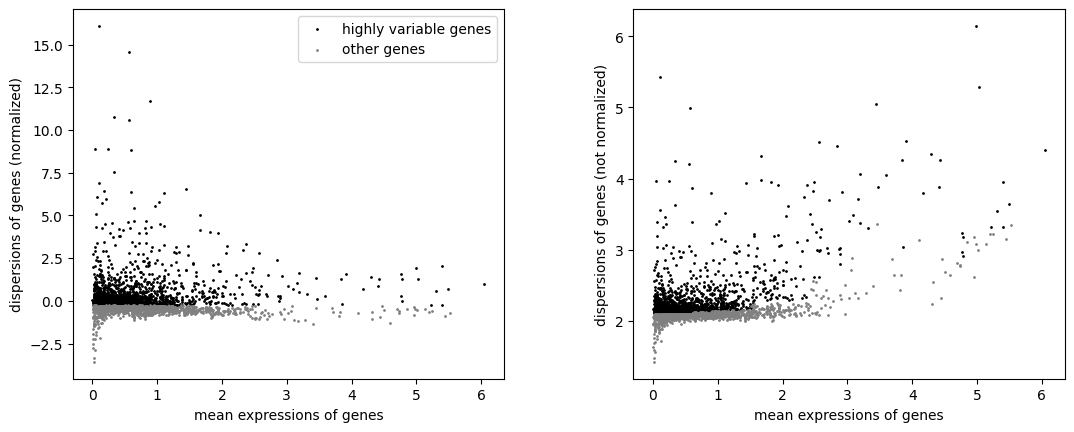

In [7]:
sc.pp.filter_genes(adata, min_cells=3)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, n_top_genes =2000, min_mean=0.0125, max_mean=9, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [8]:
adata.raw = adata.copy()
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 8626 × 2000
    obs: 'batch', 'labels'
    var: 'gene_ids', 'gene_symbols', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

# Feature encoder

In [17]:
cd.encode_features(adata, 
                   D_encode_list=[2000, 50, 8], # Encoder dimension in each layer
                   D_decode_list=[8, 500, 2000], # Decoder dimension in each layer
                   max_epoch=2000, # number of epoch
                   lr=1e-3,        # learning rate
                   device=device)


2025-12-19 11:55:19,565 - --------> Starting feature encoder ...
/Users/liuyuchen/Proj/Private_CellDiffusion/diffusion/feature_encoder.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_1 = torch.tensor(feature_matrix.to(device), dtype = feature_matrix_recover.dtype)
2025-12-19 11:55:19,657 - ------------------------> Epoch: 1/2000, Current loss: 13346551.0000
2025-12-19 11:55:21,668 - ------------------------> Epoch: 51/2000, Current loss: 6312736.5000
2025-12-19 11:55:23,654 - ------------------------> Epoch: 101/2000, Current loss: 6152743.5000
2025-12-19 11:55:25,631 - ------------------------> Epoch: 151/2000, Current loss: 6093288.5000
2025-12-19 11:55:27,596 - ------------------------> Epoch: 201/2000, Current loss: 6056023.0000
2025-12-19 11:55:29,597 - ------------------------> Epoch: 251/2000, Current loss: 6028355.50

# Integration

In [15]:
# Build the diffusion graph for data intagration

cd.inte.build_integration_graph(adata, 
                            batch_key='batch', # get batch labels
                            use_rep='X_fae',   # The same as 'use_rep' in Scanpy. Choosing cell embeddings.
                            n_edges_per_node=50, # Number of outgoing edges of each node in the diffusion graph.
                            k_mnn=50,      # K for KNNs that toward finding MNNs.
                            device=device)

In [16]:
print(adata.uns['integration_edge_index'].shape)
print("Neighbor purity: ", cd.eval.evaluate_neighbor_purity(adata, label_key='labels', graph_key='integration_edge_index'))
adata.uns['integration_edge_index']

(2, 431300)
Neighbor purity:  0.8306862972408996


array([[   0,    0,    0, ..., 8621, 8621, 8621],
       [6714, 7907, 5545, ..., 5225, 5406, 5986]])

In [24]:
cd.inte.build_mnn_graph(adata, 
                            batch_key='batch', # get batch labels
                            use_rep='X_fae',   # The same as 'use_rep' in Scanpy. Choosing cell embeddings.
                            n_edges_per_node=50, # Number of outgoing edges of each node in the diffusion graph.
                            k_mnn=50,      # K for KNNs that toward finding MNNs.
                            device=device)

In [25]:
print(adata.uns['integration_edge_index'].shape)
print("Neighbor purity: ", cd.eval.evaluate_neighbor_purity(adata, label_key='labels', graph_key='integration_edge_index'))
adata.uns['integration_edge_index']

(2, 431300)
Neighbor purity:  0.9155668907952701


array([[   0,    0,    0, ..., 8625, 8625, 8625],
       [6714, 7907, 5545, ..., 5136, 6177, 6217]])

In [ ]:
cd.eval.add_random_edges(adata, batch_key='batch', to_graph="integration_edge_index", k_add=10, seed=42, device=device)
print(adata.uns['integration_edge_index'].shape)
print("Neighbor purity: ", cd.eval.evaluate_neighbor_purity(adata, label_key='labels', graph_key='integration_edge_index'))


(2, 855217)
Neighbor purity:  0.5207730903384755


In [19]:
cd.inte.build_harmony_mnn_graph(adata, 
                            batch_key='batch', # get batch labels
                            use_rep='X_fae',   # The same as 'use_rep' in Scanpy. Choosing cell embeddings.
                            n_edges_per_node=50, # Number of outgoing edges of each node in the diffusion graph.
                            k_mnn=50,      # K for KNNs that toward finding MNNs.
                            device=device)

In [20]:
print(adata.uns['integration_edge_index'].shape)
print("Neighbor purity: ", cd.eval.evaluate_neighbor_purity(adata, label_key='labels', graph_key='integration_edge_index'))
adata.uns['integration_edge_index']

(2, 431300)
Neighbor purity:  0.8181752840250406


array([[   0,    0,    0, ..., 8625, 8625, 8625],
       [6714, 6937, 5235, ..., 6662, 3929, 5130]])

In [21]:
cd.inte.build_scvi_mnn_graph(adata, 
                            batch_key='batch', # get batch labels
                            use_rep='X_fae',   # The same as 'use_rep' in Scanpy. Choosing cell embeddings.
                            n_edges_per_node=50, # Number of outgoing edges of each node in the diffusion graph.
                            k_mnn=50,      # K for KNNs that toward finding MNNs.
                            device=device)

/Users/liuyuchen/mamba/envs/CellDiffusion_env/lib/python3.11/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/Users/liuyuchen/mamba/envs/CellDiffusion_env/lib/python3.11/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
INFO: GPU available: True (mps), used: False
2025-12-19 16:52:21,621 - GPU available: True (mps), used: False
INFO: TPU available: False, using: 0 TPU cores
2025-12-19 16:52:21,621 - TPU available: False, using: 0 TPU cores
/Users/liuyuchen/mamba/envs/CellDiffusion_env/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:175: GPU availabl

Epoch 400/400: 100%|██████████| 400/400 [04:35<00:00,  1.50it/s, v_num=1, train_loss=870]

INFO: `Trainer.fit` stopped: `max_epochs=400` reached.
2025-12-19 16:56:57,299 - `Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [04:35<00:00,  1.45it/s, v_num=1, train_loss=870]


In [22]:
print(adata.uns['integration_edge_index'].shape)
print("Neighbor purity: ", cd.eval.evaluate_neighbor_purity(adata, label_key='labels', graph_key='integration_edge_index'))
adata.uns['integration_edge_index']

(2, 431300)
Neighbor purity:  0.719976814282402


array([[   0,    0,    0, ..., 8625, 8625, 8625],
       [4855, 4825, 5718, ..., 8387, 8444, 5520]])

In [23]:
cd.inte.build_omnn_scvi_graph(adata, 
                            batch_key='batch', # get batch labels
                            use_rep='X_fae',   # The same as 'use_rep' in Scanpy. Choosing cell embeddings.
                            n_edges_per_node=50, # Number of outgoing edges of each node in the diffusion graph.
                            k_mnn=50,      # K for KNNs that toward finding MNNs.
                            device=device)

/Users/liuyuchen/mamba/envs/CellDiffusion_env/lib/python3.11/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/Users/liuyuchen/mamba/envs/CellDiffusion_env/lib/python3.11/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
INFO: GPU available: True (mps), used: False
2025-12-19 16:57:02,126 - GPU available: True (mps), used: False
INFO: TPU available: False, using: 0 TPU cores
2025-12-19 16:57:02,127 - TPU available: False, using: 0 TPU cores
/Users/liuyuchen/mamba/envs/CellDiffusion_env/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:175: GPU availabl

Epoch 400/400: 100%|██████████| 400/400 [04:27<00:00,  1.46it/s, v_num=1, train_loss=869]

INFO: `Trainer.fit` stopped: `max_epochs=400` reached.
2025-12-19 17:01:29,455 - `Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [04:27<00:00,  1.50it/s, v_num=1, train_loss=869]


In [24]:
print(adata.uns['integration_edge_index'].shape)
print("Neighbor purity: ", cd.eval.evaluate_neighbor_purity(adata, label_key='labels', graph_key='integration_edge_index'))
adata.uns['integration_edge_index']

(2, 431300)
Neighbor purity:  0.7862601437514491


array([[   0,    0,    0, ..., 8620, 8620, 8620],
       [6714, 7907, 5545, ..., 1614, 5713, 7080]])

In [9]:
# Build the input KNN adjacencies for each batch, which is used in loss function.

cd.inte.build_integration_loss_adj(adata, 
                                   use_rep='X_fae', # The same as 'use_rep' in Scanpy. Choosing cell embeddings.
                                   k=50,            # K for building KNN graph
                                   device=device)

In [10]:
cd.inte.integration_gcn(adata, 
                    use_rep='X_fae', 
                    save_key='X_gcn', 
                    max_epoch=2000, 
                    lr=1e-3, 
                    device=device,
                    num_features_gcn=8,
                    num_layers_gcn=8,
                    dropout=0.0, 
                    encoder=None, 
                    decoder=[300],
                    save_model = False, 
                    load_model_state = False,
                    loss_reduction = "sum")


2025-12-19 16:22:51,342 - --------> Starting GCN-based data integration ...
/Users/liuyuchen/Proj/Private_CellDiffusion/sc_integration/integration_GCN.py:151: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_now = torch.tensor(adjacency_list[ii].to(device), dtype = recon_adj_list[ii].dtype)
2025-12-19 16:22:52,687 - ------------------------> Epoch: 1/2000, Current loss: 26446800.0000
2025-12-19 16:23:01,098 - ------------------------> Epoch: 51/2000, Current loss: 25898752.0000
2025-12-19 16:23:09,218 - ------------------------> Epoch: 101/2000, Current loss: 25897968.0000
2025-12-19 16:23:17,368 - ------------------------> Epoch: 151/2000, Current loss: 25897860.0000
2025-12-19 16:23:25,490 - ------------------------> Epoch: 201/2000, Current loss: 25897732.0000
2025-12-19 16:23:33,626 - ------------------------> Epoch: 251/2000, C

KeyboardInterrupt: 

## View integrated embeddings

In [ ]:
sc.pp.neighbors(adata, use_rep='X_gcn', n_neighbors=50, n_pcs=8)
sc.tl.umap(adata)

/Users/liuyuchen/mamba/envs/CellDiffusion_env/lib/python3.11/site-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():


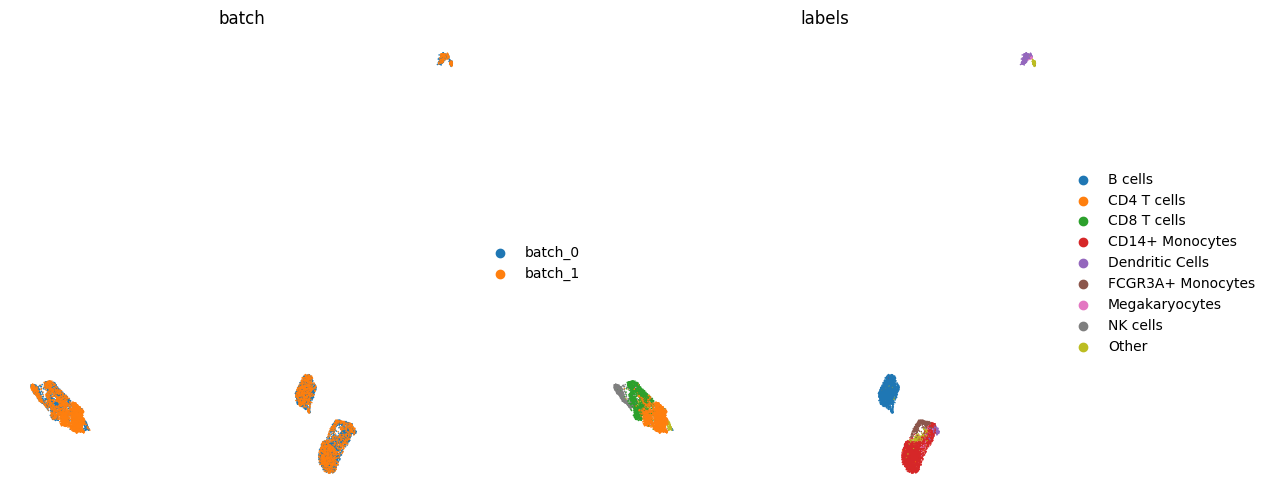

In [ ]:
from matplotlib import rcParams
FIGSIZE = (6, 6)
rcParams["figure.figsize"] = FIGSIZE

sc.pl.umap(adata, color=['batch', 'labels'], frameon=False, size=5, ncols=2)

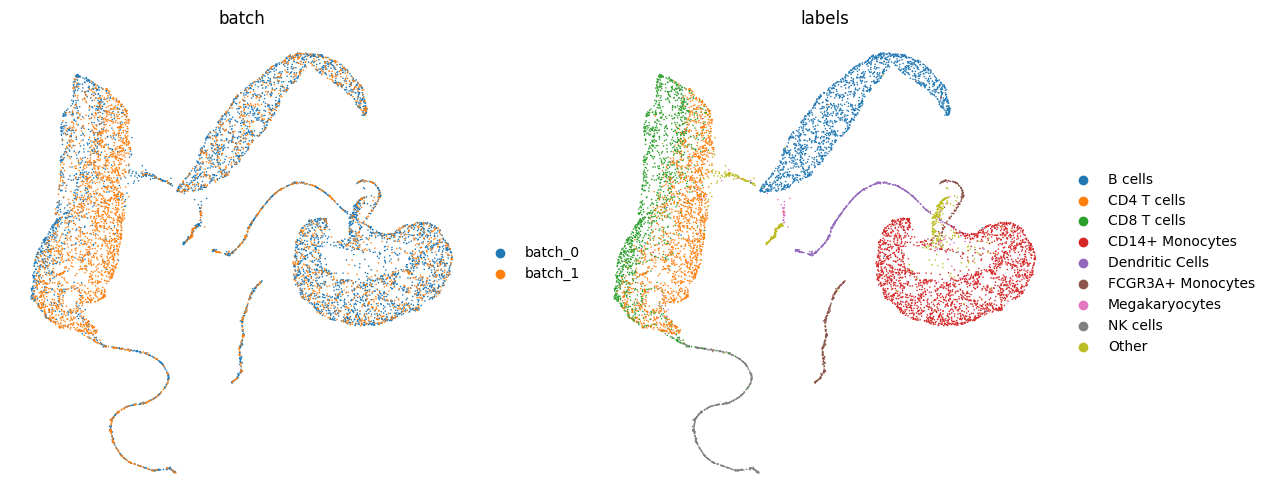

In [16]:
from matplotlib import rcParams
FIGSIZE = (6, 6)
rcParams["figure.figsize"] = FIGSIZE

sc.pl.umap(adata, color=['batch', 'labels'], frameon=False, size=5, ncols=2)

# Save integrated data

In [6]:
adata.write(OUTPUT_PATH + 'GCN_integration.h5ad')

In [5]:
adata = ad.read_h5ad(OUTPUT_PATH + 'GCN_integration.h5ad')


In [7]:
cd.eval.evaluate_mnn_neighbor_purity(adata, use_rep='X_fae', batch_key='batch', label_key='labels', k_mnn=50)

(0.9005536086139468,
 array([[4618, 4618, 4618, ..., 4617, 4617, 4617],
        [1773, 4267, 1170, ..., 5209, 4927, 5575]]))

In [9]:
cd.eval.evaluate_mnn_neighbor_purity(adata, use_rep='X_gcn', batch_key='batch', label_key='labels', k_mnn=50)

(0.7999196658097686,
 array([[4618, 4618, 4618, ..., 4617, 4617, 4617],
        [3799, 4164, 4391, ..., 7310, 6153, 6754]]))